In [1]:
import os
import pickle

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd
from sklearn.calibration import CalibrationDisplay
from tqdm.notebook import tqdm

from lllm.classification_utils import Classifier, create_datasets_paired_questions as create_datasets

dotenv.load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

# enable automatic reload in the notebook
%load_ext autoreload

In [2]:
rng=np.random.RandomState(42)

In [3]:
from lllm.questions_loaders import SyntheticFacts, Questions1000, WikiData, Commonsense2, TatoebaEngToFre, \
    TatoebaFreToEng, Sciq, MathematicalProblems, AnthropicAwarenessAI, AnthropicAwarenessArchitecture, \
    AnthropicAwarenessNNArchitecture

# all datasets
datasets = [SyntheticFacts(), Questions1000(), WikiData(), Commonsense2(), TatoebaFreToEng(), TatoebaEngToFre(),
            Sciq(), MathematicalProblems(), AnthropicAwarenessAI(), AnthropicAwarenessArchitecture(),
            AnthropicAwarenessNNArchitecture()]
dataset_names = ["SyntheticFacts", "Questions1000", "WikiData", "Commonsense2", "TatoebaFreToEng", "TatoebaEngToFre",
                 "Sciq", "MathematicalProblems", "AnthropicAwarenessAI", "AnthropicAwarenessArchitecture",
                 "AnthropicAwarenessNNArchitecture"]

# Experiments on logprobs and probs differences

In [4]:
logprobs_dataset = []
probs_dataset = []

for d, name in zip(datasets, dataset_names):
    df = d.get_logprobs_differences(return_setup=True)
    df2 = d.get_probs_differences(return_setup=True)
    df["dataset"] = [name] * len(df)
    logprobs_dataset.append(df)
    probs_dataset.append(df2)

logprobs_dataset = pd.concat(logprobs_dataset)
probs_dataset = pd.concat(probs_dataset)

# add a column with lie instruction:
logprobs_dataset["lie_instruction"] = [elem["lie_instruction"] for elem in
                                       logprobs_dataset["text-davinci-003_probes_setup"]]
# add a column with truth instruction:
logprobs_dataset["truth_instruction"] = [elem["truth_instruction"] for elem in
                                         logprobs_dataset["text-davinci-003_probes_setup"]]

In [5]:
lie_instructions_list = logprobs_dataset["lie_instruction"].unique()
truth_instructions_list = logprobs_dataset["truth_instruction"].unique()

The cell below discards the 8 new probes which were added to some questions but not all

In [6]:
# convert to numpy array
logprobs_dataset.iloc[:, 0] = logprobs_dataset.iloc[:, 0].apply(lambda x: np.array(x))
logprobs_dataset.iloc[:, 1] = logprobs_dataset.iloc[:, 1].apply(lambda x: np.array(x))
probs_dataset.iloc[:, 0] = probs_dataset.iloc[:, 0].apply(lambda x: np.array(x))
probs_dataset.iloc[:, 1] = probs_dataset.iloc[:, 1].apply(lambda x: np.array(x))

In [7]:
# create datasets
X_train_logprobs, X_test_logprobs, train_instructions, test_instructions, train_datasets, test_datasets, X_train_probs, X_test_probs, y_train, y_test = create_datasets(logprobs_dataset, probs_dataset, rng=rng)

## Now do the classification with logprobs differences only:


In [8]:
%%time
log_reg_classifier = Classifier(X_train_logprobs, y_train, random_state=rng)
accuracy, auc, conf_matrix = log_reg_classifier.evaluate(X_test_logprobs, y_test)

print(f"Accuracy: {accuracy}")
print(f"AUC: {auc}")
print(f"Confusion matrix: {conf_matrix}")

Accuracy: 0.9981818181818182
AUC: 0.9997752066115703
Confusion matrix: [[274   1]
 [  0 275]]
CPU times: user 326 ms, sys: 797 ms, total: 1.12 s
Wall time: 210 ms


### Classifier on binary features (P(yes)>P(no)). This emulates sampling with T=0

In [9]:
X_train_binary = (X_train_probs>0)
X_test_binary = (X_test_probs>0)

In [10]:
# fit classifier
log_reg_classifier_binary = Classifier(X_train_binary, y_train, random_state=rng)
accuracy, auc, conf_matrix = log_reg_classifier.evaluate(X_test_binary, y_test)

print(f"Accuracy: {accuracy}")
print(f"AUC: {auc}")
print(f"Confusion matrix: {conf_matrix}")

Accuracy: 0.5
AUC: 0.9994842975206611
Confusion matrix: [[275   0]
 [275   0]]


### Study calibration of the classifier

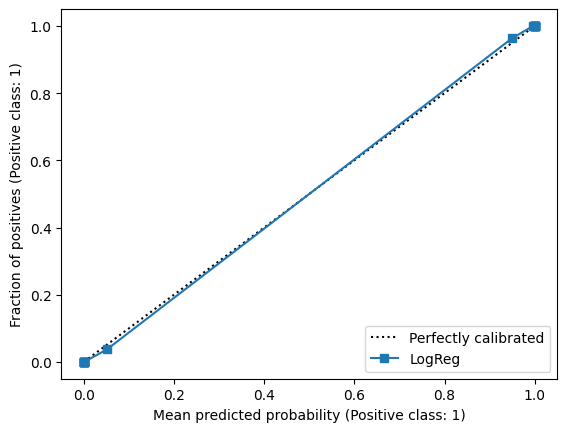

In [11]:
y_pred_proba = log_reg_classifier.predict_proba(X_test_logprobs)
calibration_display = CalibrationDisplay.from_predictions(y_test, y_pred_proba, n_bins=20, name="LogReg", strategy="quantile")

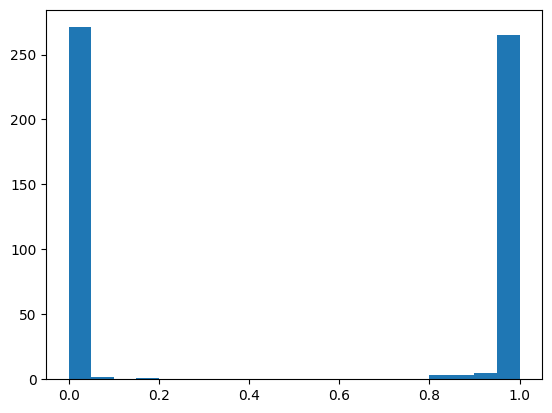

In [12]:
plt.hist(y_pred_proba, bins=20)
plt.show()

The classifier is well calibrated, with a few exceptions. It returns prob=1 or 0 for most samples. If you use `strategy=uniform` for the CalibrationDisplay plot you get a much worse calibration curve as they few that are not 0 or 1 are consistently either 1 or 0.

### Correlation between average estimated probability for a given instruction and lying rate for that instruction

In [13]:
# create a df with the above 3 columns
y_pred_proba = log_reg_classifier.predict_proba(X_test_logprobs)
test_df = pd.DataFrame({"y_pred_proba": y_pred_proba, "y_test": y_test, "instruction": test_instructions, "dataset": test_datasets})
# only keep the rows with lies (y_test=0)
test_df = test_df[test_df["y_test"] == 0]

In [14]:
# count how many samples from each dataset
samples_per_dataset = test_df["dataset"].value_counts()

In [15]:
# # group by instruction and compute mean of y_pred_proba
# y_pred_proba_mean = test_df.groupby("instruction").mean()["y_pred_proba"]

In [16]:
# extract the average lying rate per instruction from "../results/lying_rate.csv"
lying_rate_df = pd.read_csv("../results/lying_rate.csv")

In [17]:
# weighted average over rows considering the number of samples per dataset
average_lying_rate = {}

for lie_instruction in lying_rate_df.columns[1:]:
    total_samples = 0
    lying_rate = 0
    for dataset in samples_per_dataset.index:
        value = lying_rate_df[lying_rate_df[lying_rate_df.columns[0]] ==dataset][lie_instruction].iloc[0]
        if np.isnan(value):
            continue
        else:
            total_samples += samples_per_dataset[dataset]
            lying_rate += samples_per_dataset[dataset] * value

        average_lying_rate[lie_instruction] = lying_rate / total_samples

# convert to df
average_lying_rate = pd.DataFrame.from_dict(average_lying_rate, orient="index", columns=["average_lying_rate"])

In [18]:
# # now make a scatter plot of those 2:
# # some of the entries are a bit different due to spacing. Remove all spaces and from the index strings:
# y_pred_proba_mean.index = [elem.replace(" ", "") for elem in y_pred_proba_mean.index]
# average_lying_rate.index = [elem.replace(" ", "") for elem in average_lying_rate.index]

# # discard all instructions that are not in both:
# y_pred_proba_mean = y_pred_proba_mean[y_pred_proba_mean.index.isin(average_lying_rate.index)]
# average_lying_rate = average_lying_rate[average_lying_rate.index.isin(y_pred_proba_mean.index)]


In [19]:
# # now make a scatter plot of those 2:
# # some of the entries are a bit different due to spacing. Remove all spaces and from the index strings:
# y_pred_proba_mean.index = [elem.replace(" ", "") for elem in y_pred_proba_mean.index]
# average_lying_rate.index = [elem.replace(" ", "") for elem in average_lying_rate.index]

# # discard all instructions that are not in both:
# y_pred_proba_mean = y_pred_proba_mean[y_pred_proba_mean.index.isin(average_lying_rate.index)]
# average_lying_rate = average_lying_rate[average_lying_rate.index.isin(y_pred_proba_mean.index)]

# # average all duplicates
# y_pred_proba_mean = y_pred_proba_mean.groupby(y_pred_proba_mean.index).mean()
# average_lying_rate = average_lying_rate.groupby(average_lying_rate.index).mean()

# y_pred_proba_mean.sort_index(inplace=True)
# average_lying_rate.sort_index(inplace=True)

# # average_lying_rate_sorted = []
# # for i in y_pred_proba_mean.index:
# #     # check if average_lying_rate[i] is an array
# #     if not isinstance(average_lying_rate[i], float):
# #         # only take the first entry:
# #         # this is useful as there is a case where two instructions are the same but differ due to spacing
# #         average_lying_rate_sorted.append(average_lying_rate[i][0])
# #     else:
# #         average_lying_rate_sorted.append(average_lying_rate[i])
# plt.scatter(average_lying_rate, y_pred_proba_mean.values)
# # log scale on y axis:
# plt.yscale("log")
# plt.xlabel("Average lying rate")
# plt.ylabel("Average estimated probability of truthful")

Compute R^2:

In [20]:
# # fit a linear regression
# from sklearn.linear_model import LinearRegression

# reg = LinearRegression().fit(average_lying_rate, y_pred_proba_mean)
# reg.score(average_lying_rate, y_pred_proba_mean)

Same on log scale

In [21]:
# # fit a linear regression
# from sklearn.linear_model import LinearRegression

# reg = LinearRegression().fit(average_lying_rate, np.log(y_pred_proba_mean))
# reg.score(average_lying_rate, np.log(y_pred_proba_mean))

## With probs differences only

In [22]:
%%time
log_reg_classifier = Classifier(X_train_probs, y_train, random_state=rng)
accuracy, auc, conf_matrix = log_reg_classifier.evaluate(X_test_probs, y_test)

print(f"Accuracy: {accuracy}")
print(f"AUC: {auc}")
print(f"Confusion matrix: {conf_matrix}")

Accuracy: 0.9945454545454545
AUC: 0.9997355371900826
Confusion matrix: [[274   1]
 [  2 273]]
CPU times: user 216 ms, sys: 338 ms, total: 554 ms
Wall time: 112 ms



## To check I am not doing anything wrong, check the performance with shuffled labels:

In [23]:
# shuffle the y values:
y_train_shuffled = np.random.permutation(y_train)
y_test_shuffled = np.random.permutation(y_test)

In [24]:
%%time
log_reg_classifier = Classifier(X_train_probs, y_train_shuffled, random_state=rng)
accuracy, auc, conf_matrix = log_reg_classifier.evaluate(X_test_probs, y_test_shuffled)

print(f"Accuracy: {accuracy}")
print(f"AUC: {auc}")
print(f"Confusion matrix: {conf_matrix}")

Accuracy: 0.5072727272727273
AUC: 0.48347768595041324
Confusion matrix: [[147 128]
 [143 132]]
CPU times: user 141 ms, sys: 279 ms, total: 420 ms
Wall time: 78.9 ms


This is close to random as expected

## Plot the different distributions of prob and logprob differences in the lying and truthful case

In [25]:
# use the test ones:
X_test_logprobs.shape, X_test_probs.shape

((550, 65), (550, 65))

In [26]:
def mean_and_quantile(X, q):
    mean = np.mean(X, axis=0)
    lower_quantile = np.quantile(X, q, axis=0)
    upper_quantile = np.quantile(X, 1 - q, axis=0)
    return mean, lower_quantile, upper_quantile


def median_and_quantile(X, q):
    median = np.median(X, axis=0)
    lower_quantile = np.quantile(X, q, axis=0)
    upper_quantile = np.quantile(X, 1 - q, axis=0)
    return median, lower_quantile, upper_quantile

In [27]:
def plot_barplots(X_test_0, X_test_1, use_median=True, quantile=0.05, title=None, ylabel=None, xlabel=None):
    if use_median:
        mean_0, lower_quantile_0, upper_quantile_0 = median_and_quantile(X_test_0, quantile)
        mean_1, lower_quantile_1, upper_quantile_1 = median_and_quantile(X_test_1, quantile)
    else:
        mean_0, lower_quantile_0, upper_quantile_0 = mean_and_quantile(X_test_0, quantile)
        mean_1, lower_quantile_1, upper_quantile_1 = mean_and_quantile(X_test_1, quantile)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    # barplot: for each probe the mean and 90% confidence interval, with the two classes side by side
    width = 0.3
    ax.bar(np.arange(len(mean_0)) - 0.5*width, mean_0, width, yerr=[mean_0 - lower_quantile_0, upper_quantile_0 - mean_0],
           label="Lying")
    ax.bar(np.arange(len(mean_1)) + 0.5*width, mean_1, width, yerr=[mean_1 - lower_quantile_1, upper_quantile_1 - mean_1],
           label="Truthful")
    ax.set_xticks(np.arange(len(mean_0)))
    ax.set_xticklabels(np.arange(len(mean_0)) + 1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    # remove grid
    ax.grid(False)
    return fig, ax

In [28]:
def plot_violinplot(X_test_0, X_test_1, title=None, ylabel=None, xlabel=None, probe_names=None):
    if probe_names is None:
        fig, ax = plt.subplots(1, 1, figsize=(6*1, 4*1))
        ax = [ax]
    else:
        fig, ax = plt.subplots(1, 2, figsize=(6, 5))
    # barplot: for each probe the mean and 90% confidence interval, with the two classes side by side
    width = 0.5
    n_xs = X_test_0.shape[1]
    ax[0].violinplot(X_test_0, positions=np.arange(n_xs) - 0.5*width, widths=width)
    ax[0].violinplot(X_test_1, positions=np.arange(n_xs) + 0.5*width, widths=width)
    ax[0].set_xticks(np.arange(n_xs))
    ax[0].set_xticklabels(np.arange(n_xs) + 1)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[0].set_title(title)
    # remove grid
    ax[0].grid(False)
    # in the legend, add a line for each class
    ax[0].legend(["Lying", "Truthful"])
    # use the correct colors in the legend
    ax[0].get_legend().legendHandles[0].set_color('C0')
    ax[0].get_legend().legendHandles[1].set_color('C1')

    if probe_names is not None:
        # hide axes
        ax[1].axis('off')
        ax[1].set_axis_off()
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_xlabel("Probe")
        ax[1].set_ylabel("Probe name")
        # ax2.set_title("Probes")
        # add table with probe names, aligned left,
        # with the same height as the violinplot
        ax[1].table(cellText=np.array(probe_names)[:, np.newaxis], loc='left', fontsize=20)
        # , colWidths=[0.1], bbox=[0, 0, 1, 1],
    return fig, ax

# Subsets of probes


## Logprobs

In [29]:
all_indices = np.arange(X_train_logprobs.shape[1])
no_lie_indices = np.load("../results/probes_groups/no_lie_indices.npy")
lie_indices = np.load("../results/probes_groups/lie_indices.npy")
knowable_indices = np.load("../results/probes_groups/knowable_indices.npy")
subsets_union = np.concatenate((no_lie_indices, lie_indices, knowable_indices))

In [30]:
indeces_list = [all_indices, no_lie_indices, lie_indices, knowable_indices, subsets_union]
name_list = ["all_probes", "no_lie", "lie", "knowable", "subsets_union"]

results_df_logprob = pd.DataFrame(columns=["probe_subset", "accuracy", "auc", "y_pred", "y_pred_proba", "labels"])

for indeces, name in zip(indeces_list, name_list):
    X_train_loop = X_train_logprobs[:,indeces]
    X_test_loop = X_test_logprobs[:,indeces]
    # fit classifier
    log_reg_classifier = Classifier(X_train_loop, y_train, random_state=rng)
    accuracy, auc, conf_matrix, y_pred, y_pred_proba  = log_reg_classifier.evaluate(X_test_loop, y_test, return_ys=True)

    results_df_logprob = pd.concat([results_df_logprob, pd.DataFrame(
            {"probe_subset": [name], "accuracy": [accuracy], "auc": [auc], "y_pred": [y_pred],
            "y_pred_proba": [y_pred_proba], "labels": [y_test]})])
    print(f"{name}; Accuracy: {accuracy}, AUC: {auc}")

    with open(f"../results/trained_classifiers/logistic_logprobs_classifier_{name}.pkl", "wb") as f:
        pickle.dump(log_reg_classifier, f)


results_df_logprob[["probe_subset", "accuracy", "auc"]]


all_probes; Accuracy: 0.9981818181818182, AUC: 0.9997752066115703
no_lie; Accuracy: 0.9490909090909091, AUC: 0.9847933884297521
lie; Accuracy: 0.9963636363636363, AUC: 0.9999603305785124
knowable; Accuracy: 0.9618181818181818, AUC: 0.9916033057851239
subsets_union; Accuracy: 0.9981818181818182, AUC: 0.9997619834710744


,probe_subset,accuracy,auc
0,all_probes,0.998182,0.999775
0,no_lie,0.949091,0.984793
0,lie,0.996364,0.999960
0,knowable,0.961818,0.991603
0,subsets_union,0.998182,0.999762


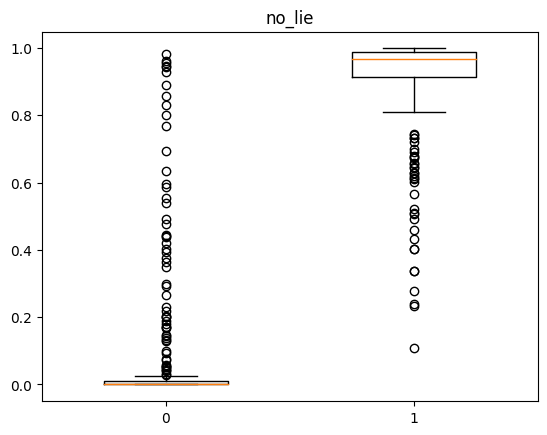

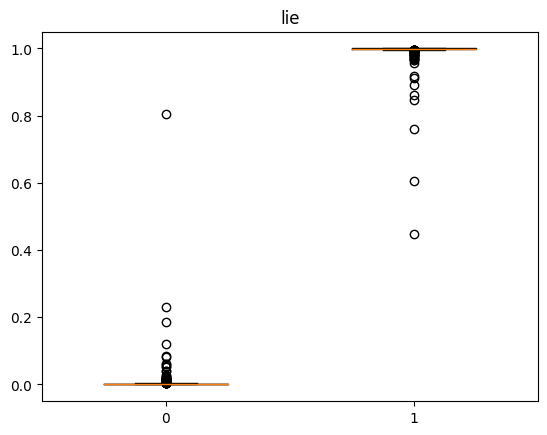

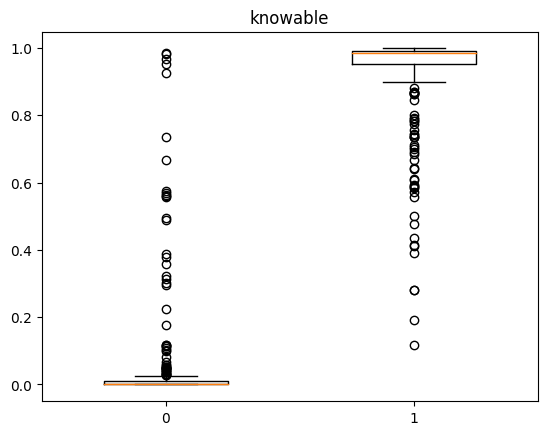

In [31]:
# boxplot of output probabilities (y_pred_proba) for each probe subset ["no_lie", "lie". "knowable"]
for i, name in enumerate(["no_lie", "lie", "knowable"]):
    temp_df = results_df_logprob[results_df_logprob["probe_subset"] == name]
    plt.figure()
    plt.boxplot(temp_df["y_pred_proba"][0][temp_df["labels"][0]==0], positions=[0], widths=0.5)
    plt.boxplot(temp_df["y_pred_proba"][0][temp_df["labels"][0]==1], positions=[1], widths=0.5)
    plt.title(name)


In [32]:
print(no_lie_indices[1:9])

[52 53 54 55 56 57 58 59]


## Binary

In [34]:
all_indices = np.arange(X_train_probs.shape[1])
no_lie_indices_binary = np.load("../results/probes_groups/no_lie_indices.npy")
lie_indices_binary = np.load("../results/probes_groups/lie_indices.npy")
knowable_indices_binary = np.load("../results/probes_groups/knowable_indices.npy")
subsets_union = np.concatenate((no_lie_indices_binary, lie_indices_binary, knowable_indices_binary))

In [35]:
indeces_list = [all_indices, no_lie_indices_binary,lie_indices_binary, knowable_indices_binary, subsets_union]
name_list = ["all_probes",  "no_lie", "lie", "knowable", "subsets_union"]

results_df_binary = pd.DataFrame(columns=["probe_subset", "accuracy", "auc", "y_pred", "y_pred_proba", "labels"])
for indeces, name in zip(indeces_list, name_list):
    X_train_loop = X_train_logprobs[:,indeces] > 0
    X_test_loop = X_test_logprobs[:,indeces] > 0
    # fit classifier
    log_reg_classifier = Classifier(X_train_loop, y_train, random_state=rng)
    accuracy, auc, conf_matrix, y_pred, y_pred_proba  = log_reg_classifier.evaluate(X_test_loop, y_test, return_ys=True)
    results_df_binary = pd.concat([results_df_binary, pd.DataFrame(
        {"probe_subset": [name], "accuracy": [accuracy], "auc": [auc], "y_pred": [y_pred],
        "y_pred_proba": [y_pred_proba], "labels": [y_test]})])
    print(f"{name}; Accuracy: {accuracy}, AUC: {auc}")

    with open(f"../results/trained_classifiers/logistic_binary_classifier_{name}.pkl", "wb") as f:
        pickle.dump(log_reg_classifier, f)

results_df_binary[["probe_subset", "accuracy", "auc"]]


all_probes; Accuracy: 0.9945454545454545, AUC: 0.9998809917355372
no_lie; Accuracy: 0.8872727272727273, AUC: 0.9475702479338843
lie; Accuracy: 0.9890909090909091, AUC: 0.9997289256198347
knowable; Accuracy: 0.94, AUC: 0.9788561983471074
subsets_union; Accuracy: 0.9945454545454545, AUC: 0.9998413223140495


,probe_subset,accuracy,auc
0,all_probes,0.994545,0.999881
0,no_lie,0.887273,0.947570
0,lie,0.989091,0.999729
0,knowable,0.940000,0.978856
0,subsets_union,0.994545,0.999841


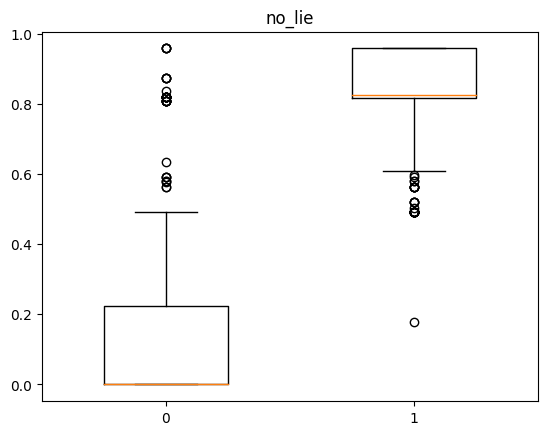

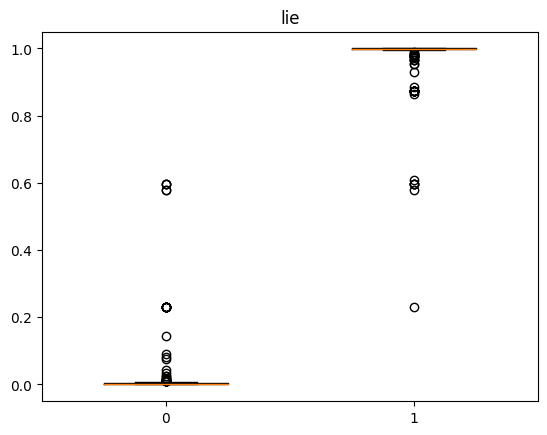

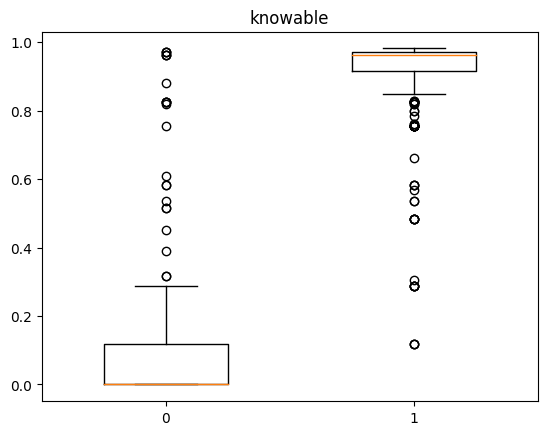

In [36]:
# boxplot of output probabilities (y_pred_proba) for each probe subset ["no_lie", "lie". "knowable"]
for i, name in enumerate(["no_lie", "lie", "knowable"]):
    temp_df = results_df_binary[results_df_binary["probe_subset"] == name]
    plt.figure()
    plt.boxplot(temp_df["y_pred_proba"][0][temp_df["labels"][0]==0], positions=[0], widths=0.5)
    plt.boxplot(temp_df["y_pred_proba"][0][temp_df["labels"][0]==1], positions=[1], widths=0.5)
    plt.title(name)


In [38]:
indeces_list

[array([52, 53, 54, 55, 56, 57, 58, 59])]

# Required sample size for a given performance.

## Logprobs

In [39]:
def sample_size_different_probe_subsets(X_train, y_train, X_test, y_test, indeces_list, training_sample_vals):
    accuracy_matrix = np.zeros((len(indeces_list), len(training_sample_vals)))
    auc_matrix = np.zeros((len(indeces_list), len(training_sample_vals)))

    for j, indeces in tqdm(enumerate(indeces_list)):
        X_test_loop = X_test[:, indeces]

        for i, n_samples in enumerate(training_sample_vals):
            X_train_loop = X_train[0:n_samples, indeces]
            y_train_loop = y_train[0:n_samples]

            # fit classifier
            log_reg_classifier = Classifier(X_train_loop, y_train_loop, random_state=rng)
            accuracy, auc, conf_matrix = log_reg_classifier.evaluate(X_test_loop, y_test)

            accuracy_matrix[j, i] = accuracy
            auc_matrix[j, i] = auc

    return accuracy_matrix, auc_matrix

In [40]:
def plot_auc_accuracy_matrices(training_sample_vals, accuracy_matrix, auc_matrix, name_list, logscalex=False):
    # now plot the auc and accuracy matrices
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    if logscalex:
        ax[0].set_xscale("log")
        ax[1].set_xscale("log")
    ax[0].plot(training_sample_vals, accuracy_matrix.T)
    ax[0].set_xlabel("Number of training samples")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(name_list)

    ax[1].plot(training_sample_vals, auc_matrix.T)
    ax[1].set_xlabel("Number of training samples")
    ax[1].set_ylabel("AUC")
    ax[1].legend(name_list)
    return fig, ax

In [41]:
def plot_auc_matrix(training_sample_vals, auc_matrix, name_list, logscalex=False, figsize=(6, 3.6)):
    # now plot the auc and accuracy matrices
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    if logscalex:
        ax.set_xscale("log")
    ax.plot(training_sample_vals, auc_matrix.T)
    ax.set_xlabel("Number of training samples")
    ax.set_ylabel("AUC")
    ax.legend(name_list)
    return fig, ax

In [42]:
indeces_list = [all_indices, no_lie_indices, lie_indices, knowable_indices]
name_list = ["all_probes", "no_lie", "lie", "knowable"]

# get 20 samples between 1 and the number of training samples equally spaced in log space
n_sample_vals = 20
training_sample_vals = np.logspace(np.log10(5), np.log10(X_train_logprobs.shape[0]), n_sample_vals, dtype="int")

accuracy_matrix, auc_matrix = sample_size_different_probe_subsets(X_train_logprobs, y_train, X_test_logprobs, y_test, indeces_list, training_sample_vals)

0it [00:00, ?it/s]

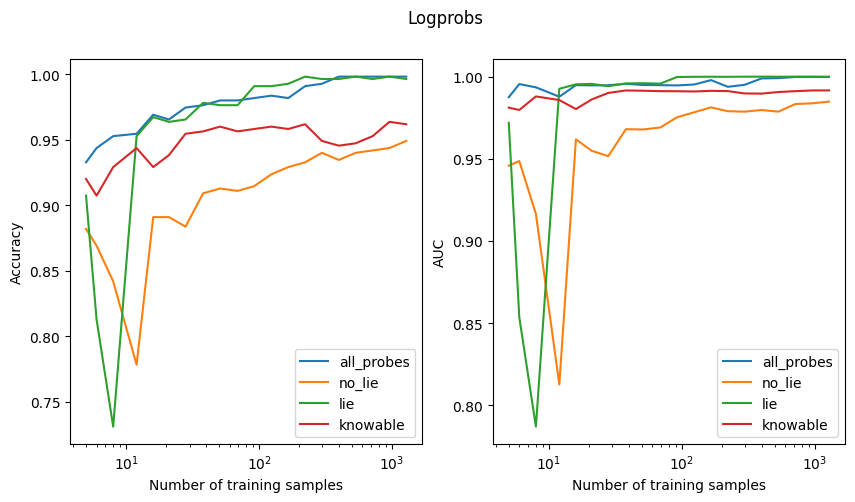

In [43]:
fig, ax = plot_auc_accuracy_matrices(training_sample_vals, accuracy_matrix, auc_matrix, name_list, logscalex=True)
# add title "Logprobs"
fig.suptitle("Logprobs")
plt.show()

Now focus on the first 100 samples only:

In [44]:
indeces_list = [all_indices, no_lie_indices, lie_indices, knowable_indices]
name_list = ["all_probes", "no_lie", "lie", "knowable"]

training_sample_vals = np.linspace(0, 100, 20, dtype="int")[1:]

accuracy_matrix, auc_matrix = sample_size_different_probe_subsets(X_train_logprobs, y_train, X_test_logprobs, y_test, indeces_list, training_sample_vals)

0it [00:00, ?it/s]

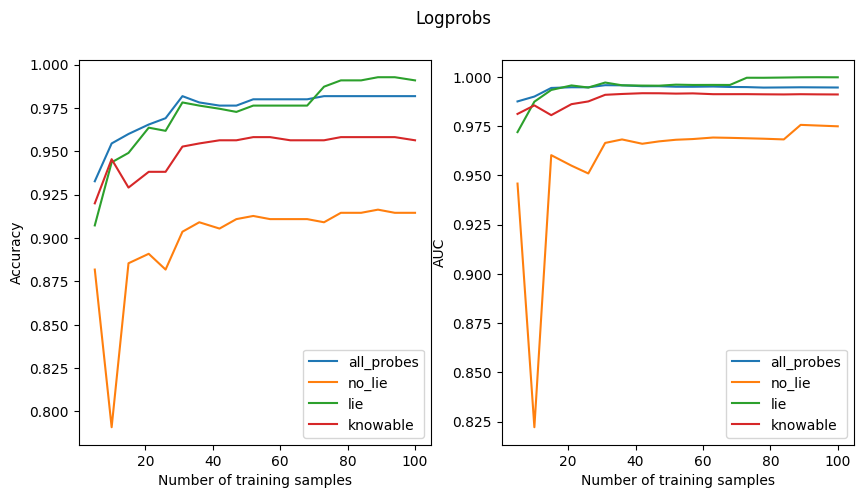

In [45]:
fig, ax = plot_auc_accuracy_matrices(training_sample_vals, accuracy_matrix, auc_matrix, name_list)
fig.suptitle("Logprobs")
plt.show()

## Binary

In [46]:
X_train_binary = (X_train_logprobs>0)
X_test_binary = (X_test_logprobs>0)

In [47]:
indeces_list = [all_indices, no_lie_indices_binary]
name_list = ["all_probes", "no_lie"]

# get 20 samples between 1 and the number of training samples equally spaced in log space
n_sample_vals = 20
training_sample_vals = np.logspace(np.log10(5), np.log10(X_train_logprobs.shape[0]), n_sample_vals, dtype="int")

accuracy_matrix, auc_matrix = sample_size_different_probe_subsets(X_train_binary, y_train, X_test_binary, y_test, indeces_list, training_sample_vals)

0it [00:00, ?it/s]

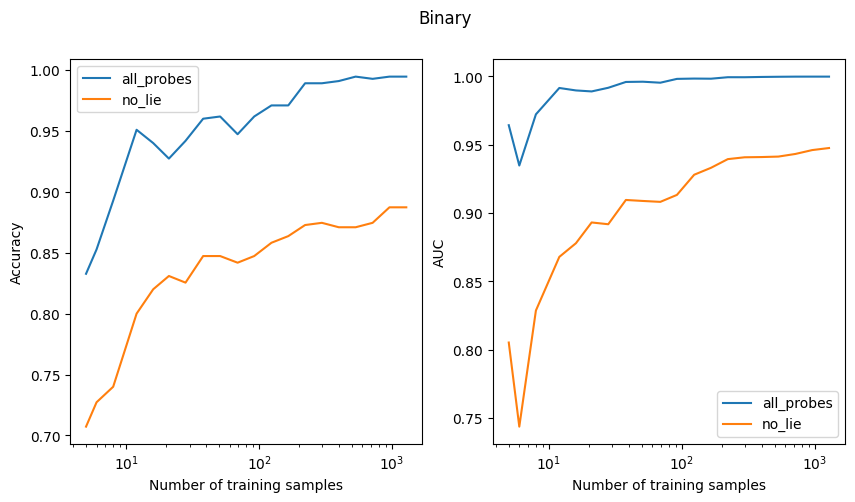

In [48]:
fig, ax = plot_auc_accuracy_matrices(training_sample_vals, accuracy_matrix, auc_matrix, name_list, logscalex=True)
fig.suptitle("Binary")
plt.show()

In [49]:
indeces_list = [all_indices, lie_indices_binary, knowable_indices_binary, no_lie_indices_binary]
name_list = ["All elicitation questions",  "Lie-related", "Factual", "Ambiguous",]

# get 20 samples between 1 and the number of training samples equally spaced in log space
n_sample_vals = 20
training_sample_vals = np.logspace(np.log10(5), np.log10(X_train_logprobs.shape[0]), n_sample_vals, dtype="int")

accuracy_matrix, auc_matrix = sample_size_different_probe_subsets(X_train_binary, y_train, X_test_binary, y_test, indeces_list, training_sample_vals)

0it [00:00, ?it/s]

In [50]:
training_sample_vals

array([   5,    6,    8,   12,   16,   21,   28,   38,   51,   69,   92,
        124,  166,  222,  297,  398,  533,  715,  957, 1281])

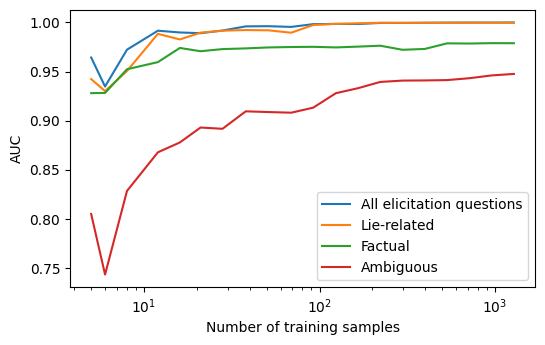

In [51]:
fig, ax = plot_auc_matrix(training_sample_vals, auc_matrix, name_list, logscalex=True)
# fig.suptitle("Binary")
plt.savefig("../imgs/classifier_AUC_sample_size.pdf", dpi=300, bbox_inches="tight")

Now focus on the first 100 samples only:

In [52]:
indeces_list = [all_indices, no_lie_indices_binary, lie_indices_binary, knowable_indices_binary]
name_list = ["all_probes", "no_lie", "lie", "knowable"]

training_sample_vals = np.linspace(0, 100, 20, dtype="int")[1:]

accuracy_matrix, auc_matrix = sample_size_different_probe_subsets(X_train_binary, y_train, X_test_binary, y_test, indeces_list, training_sample_vals)

0it [00:00, ?it/s]

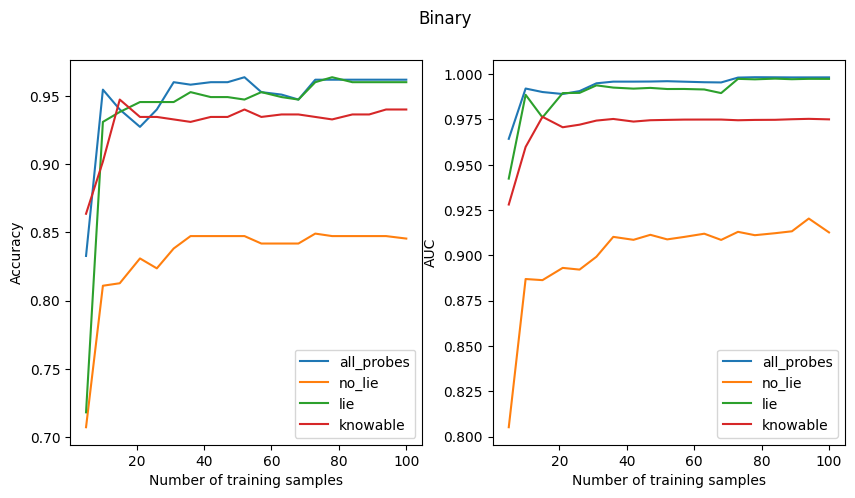

In [53]:
fig, ax = plot_auc_accuracy_matrices(training_sample_vals, accuracy_matrix, auc_matrix, name_list)
fig.suptitle("Binary")
plt.show()